In [1]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd


def read_tsv_y(file_path):
    df = pd.read_csv(file_path,  # Replace with your file name
                    sep='\t',          # Tab separator for TSV files
                    skiprows=11,       # Skip the first 10 rows
                    names=['index', 'time', 'x', 'y', 'z'])  # Set new column names

    # Display the first few rows to verify
    y = df['y'].to_numpy()
    t = df['time'].to_numpy()
    return t,y

def fft(data, fs):
    window = np.hanning(len(data))
    windowed_data = data*window
    fft_values = np.fft.fft(windowed_data)
    window = np.hanning(len(data))
    windowed_data = data * window

    # Utför Fouriertransformen
    fft_values = np.fft.fft(windowed_data)
    frequencies = np.fft.fftfreq(len(data), d=1/fs)

    # Hämta endast positiva frekvenser (speglingen)
    positive_freq_indices = np.where(frequencies > 0.3)
    frequencies = frequencies[positive_freq_indices]
    fft_magnitude = np.abs(fft_values[positive_freq_indices])
    return frequencies, fft_magnitude

def max_1(f, a):
    peaks, _ = find_peaks(a)
    
    # Check if there are at least two peaks

    # Get the values at the peaks and sort to find the indices of the top two
    top_one_indices = peaks[np.argsort(a[peaks])[-1:]]
    f_max = f[top_one_indices]
    # Return sorted indices of the two largest peaks
    return f_max

def filter(t, z, t1, t2):
    t3 = np.where((t >= t1) & (t <= t2))[0]
    return t[t3], z[t3]

def calculate_period(t, y, min_distance=100):
    # Hitta alla lokala maxima i y-arrayen
    peaks, _ = find_peaks(y, distance=min_distance)

    positive_peaks = [p for p in peaks if y[p] > 0]
    # Extrahera tiderna för dessa toppar
    peak_times = t[positive_peaks]
    
    # Beräkna skillnaden mellan närliggande peak-tider (periodtider)
    period_times = np.diff(peak_times)
    plt.plot(t, y)
    plt.scatter(t[positive_peaks], y[positive_peaks])
    
    # Beräkna medelvärdet för att få en ungefärlig periodtid
    average_period = np.mean(period_times)
    
    return average_period

In [2]:

def period_pendel_2(filepath, tn, tu, l):
    t, y = read_tsv_y(filepath)
    y = y-y[0]
    y_max = max(np.abs(y))
    thetamax = np.arcsin((y_max-y[0])/l)
    t, y = filter(t, y, tn, tu)
    
    T = calculate_period(t, y)

    #plt.plot(t, theta1)
    #plt.plot(f1, A)
    #f_max = max_1(f1, A)
    #T = 1/(f_max)
    #print(thetamax)
    #print(T)
    return T, thetamax


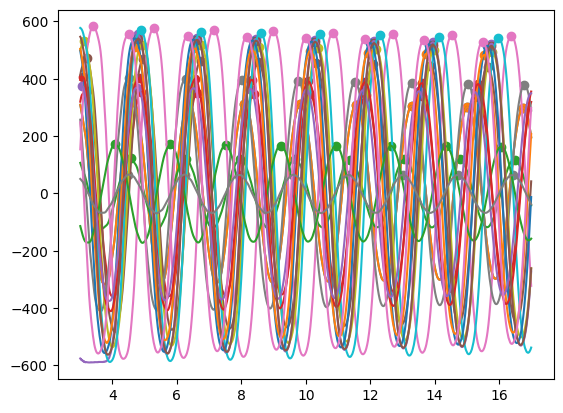

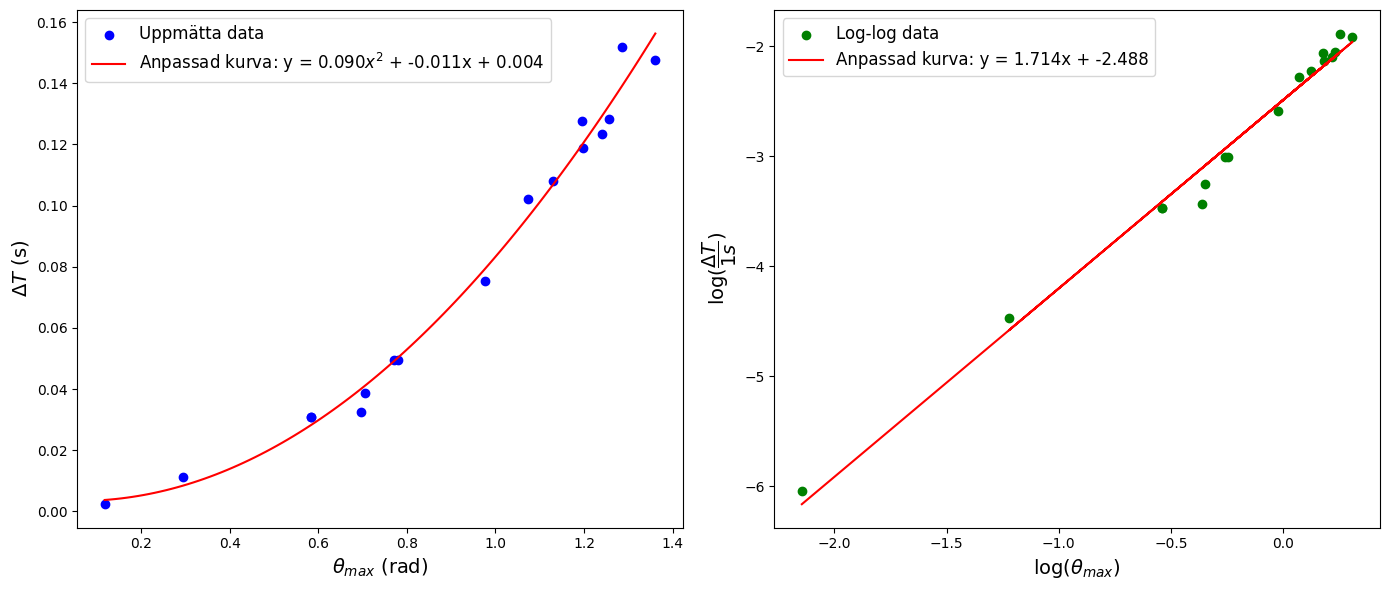

Lutning på rät linje: 1.71397882787013


In [3]:
#l till reflex var 62 cm, l till masscentrum 70 cm

filer = ["Pendel_L_62/Pendel_L63_1.tsv", "Pendel_L_62/Pendel_L63_2.tsv", "Pendel_L_62/Pendel_L63_3.tsv", "Pendel_L_62/Pendel_L63_4.tsv", "Pendel_L_62/Pendel_L63_5.tsv", "Pendel_L_62/Pendel_L63_6.tsv", "Pendel_L_62/Pendel_L63_7.tsv", "Pendel_L_62/Pendel_L63_8.tsv", "Pendel_L_62/Pendel_L63_9.tsv", "Pendel_L_62/Pendel_L63_10.tsv", "Pendel_L_62/Pendel_L63_11.tsv", "Pendel_L_62/Pendel_L63_12.tsv", "Pendel_L_62/Pendel_L63_13.tsv", "Pendel_L_62/Pendel_L63_14.tsv", "Pendel_L_62/Pendel_L63_15.tsv", "Pendel_L_62/Pendel_L63_16.tsv", "Pendel_L_62/Pendel_L63_17.tsv", "Pendel_L_62/Pendel_L63_Liten.tsv"]

x = []
y = []


for i in filer:
    result = period_pendel_2(i, 3, 20, 620)  
    a, b = result
    x.append(b)  
    y.append(a)  


x = np.array(x)
y = np.array(y)

# Hitta och ta bort minsta värdet för periodtider
mini = np.argmin(y)

deltay = y - np.min(y)
x = np.delete(x, mini)
deltay = np.delete(deltay, mini)

# Filtrera bort vinklar mindre än 0.1 radianer
mask = x > 0.1
x = x[mask]
deltay = deltay[mask]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


ax1.scatter(x, deltay, color='blue', label="Uppmätta data")


coeffs_quadratic = np.polyfit(x, deltay, 2)
x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = np.polyval(coeffs_quadratic, x_fit)

# Plot av andragradspassning
ax1.plot(x_fit, y_fit, color="red", label=rf'Anpassad kurva: y = {coeffs_quadratic[0]:.3f}$x^2$ + {coeffs_quadratic[1]:.3f}x + {coeffs_quadratic[2]:.3f}')

# Titel och axlar
#ax1.set_title('Plott av datan och matchning med andragradskurva', fontsize=16)
ax1.set_xlabel(r'$\theta_{max}$ (rad)', fontsize=14)
ax1.set_ylabel(r'$\Delta T$ (s)', fontsize=14)
ax1.legend(loc='upper left', fontsize=12)


x_log = np.log(x)
y_log = np.log(deltay)


ax2.scatter(x_log, y_log, color='green', label="Log-log data")

# Linjär polyfit för log-log data
coeffs_linear = np.polyfit(x_log, y_log, 1)
y_log_fit = coeffs_linear[0] * x_log + coeffs_linear[1]

# Plot av linjär passning
ax2.plot(x_log, y_log_fit, color="red", label=rf'Anpassad kurva: y = {coeffs_linear[0]:.3f}x + {coeffs_linear[1]:.3f}')

# Titel och axlar
#ax2.set_title('Logarimterad plot och linjär passning', fontsize=16)
ax2.set_xlabel(r'$\log(\theta_{max})$', fontsize=14)
ax2.set_ylabel(r'$\log(\dfrac{\Delta T}{1s})$', fontsize=14)
ax2.legend(loc='upper left', fontsize=12)

# Visa plotten
plt.tight_layout()
plt.show()
print("Lutning på rät linje: {}".format(coeffs_linear[0]))

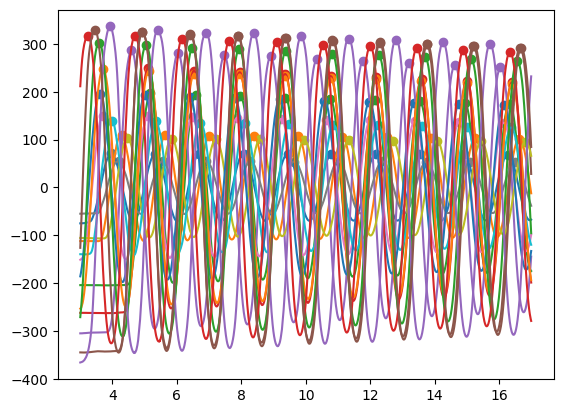

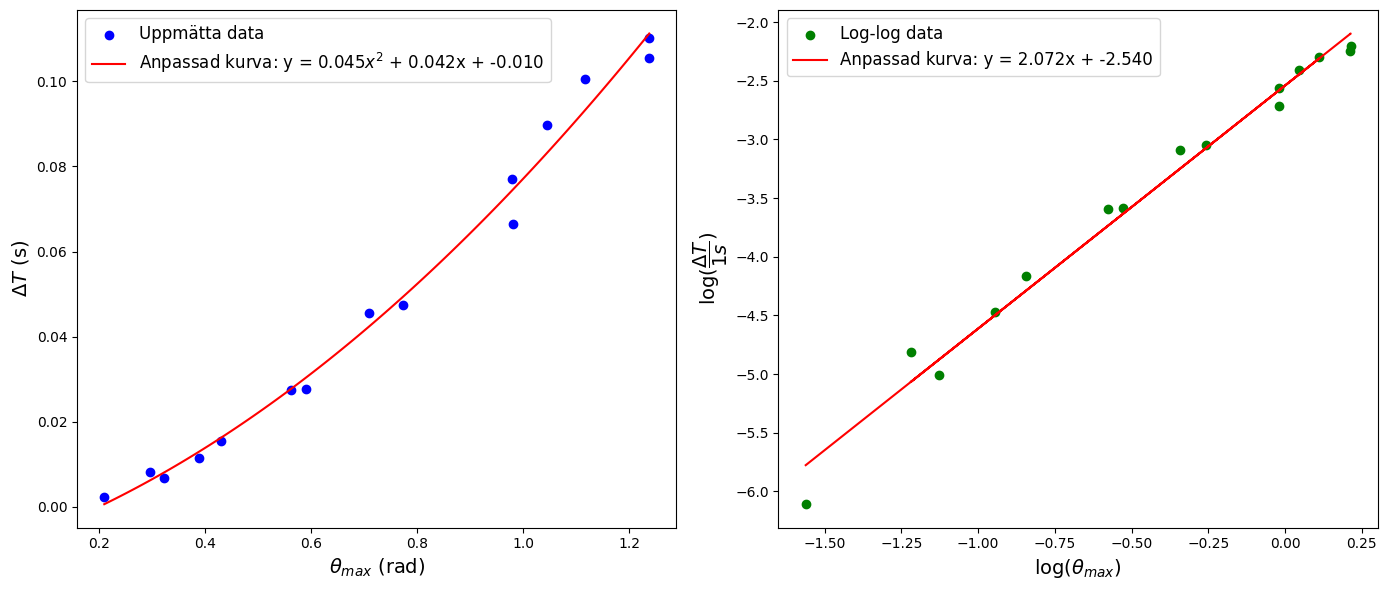

Lutning på rät linje: 2.0722907002742605


In [4]:
#l till reflextejpen var 39cm, l till masscentrum var 45

filer = ["Pendel1/Pendel_Liten.tsv", "Pendel1/Pendel1.tsv", "Pendel1/Pendel2.tsv","Pendel1/Pendel3.tsv", "Pendel1/Pendel4.tsv", "Pendel1/Pendel5.tsv", "Pendel1/Pendel6.tsv","Pendel1/Pendel7.tsv","Pendel1/Pendel8.tsv", "Pendel1/Pendel9.tsv","Pendel1/Pendel10.tsv","Pendel1/Pendel11.tsv","Pendel1/Pendel12.tsv","Pendel1/Pendel13.tsv","Pendel1/Pendel14.tsv","Pendel1/Pendel15.tsv"]


x_1 = []
y_1 = []


for i in filer:
    result = period_pendel_2(i, 3, 20, 390)  
    a, b = result
    x_1.append(b)  
    y_1.append(a)  


x_1 = np.array(x_1)
y_1 = np.array(y_1)

# Hitta och ta bort minsta värdet för periodtider
mini = np.argmin(y_1)

deltay = y_1 - np.min(y_1)
x_1 = np.delete(x_1, mini)
deltay = np.delete(deltay, mini)

# Filtrera bort vinklar mindre än 0.1 radianer
mask = x_1 > 0.1
x_1 = x_1[mask]
deltay = deltay[mask]

# Skapa den första grafen: Scatter och andragradspassning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
ax1.scatter(x_1, deltay, color='blue', label="Uppmätta data")

# Andragradspolyfit
andra_koef = np.polyfit(x_1, deltay, 2)
x_fit = np.linspace(np.min(x_1), np.max(x_1), 100)
y_fit = np.polyval(andra_koef, x_fit)

ax1.plot(x_fit, y_fit, color="red", label=rf'Anpassad kurva: y = {andra_koef[0]:.3f}$x^2$ + {andra_koef[1]:.3f}x + {andra_koef[2]:.3f}')

# Titel och axlar
#ax1.set_title('Plott av datan och matchning med andragradskurva', fontsize=16)
ax1.set_xlabel(r'$\theta_{max}$ (rad)', fontsize=14)
ax1.set_ylabel(r'$\Delta T$ (s)', fontsize=14)
ax1.legend(loc='upper left', fontsize=12)


x_log = np.log(x_1)
y_log = np.log(deltay)


ax2.scatter(x_log, y_log, color='green', label="Log-log data")

# Linjär polyfit för log-log data
linjära_koef = np.polyfit(x_log, y_log, 1)
y_log_fit = linjära_koef[0] * x_log + linjära_koef[1]

# Plot av linjär passning
ax2.plot(x_log, y_log_fit, color="red", label=rf'Anpassad kurva: y = {linjära_koef[0]:.3f}x + {linjära_koef[1]:.3f}')

# Titel och axlar
#ax2.set_title('Logarimterad plot och linjär passning', fontsize=16)
ax2.set_xlabel(r'$\log(\theta_{max})$', fontsize=14)
ax2.set_ylabel(r'$\log(\dfrac{\Delta T}{1s})$', fontsize=14)
ax2.legend(loc='upper left', fontsize=12)


# Visa plotten
plt.tight_layout()
plt.show()
print("Lutning på rät linje: {}".format(linjära_koef[0]))